# Tutorial: Nonadiabatic Dynamics with QTAG Trajectories

The purpose of this tutorial is to guide the user through running a QTAG calculation of wavepacket dynamics, including initializing input parameter dictionaries and visualizing the resultant data with Python's MatPlotLib.

## Table of Contents

1. [Defining the Model Hamiltonian](#Defining-the-Model-Hamiltonian)

2. [Setting up and executing QTAG dynamics](#2)

   2.1. [Initializing the grid (Gaussian Basis Functions, GBFs)](#2.1)
   
   2.2. [Initializing the wavefunction](#2.2)
   
   2.3. [Running the dynamics](#2.3)
  
3. [Data Visualization](#3)

   3.1. [Wavefunction plotting](#3.1)
   
   3.2. [Energy and population plotting](#3.2)
   
   3.3. [Trajectory information plotting](#3.3)

4. [Exercises](#exercises)

## Learning Objectives

+ To be able to create a custom potential for the QTAG algorithm
+ To be able to run a QTAG dynamics calculation
+ To be able to visualize QTAG-guided trajectories and wavefunctions

## Functions

- `libra.py`
  - `models`
    - `Ferretti`
      - [`Ferretti`](#Ferretti-1)
    - `Holstein`
      - [`Holstein5`](#Holstein5-1)
  - `dynamics`
    - `qtag`
      - `compute`
        - [`wfc_calc_nD`](#wfc_calc_nD-1)
        - [`run_qtag`](#run_qtag-1)
      - `initialize`
        - [`gbfs`](#gbfs-1)
        - [`wfc_centers`](#wfc_centers-1)
        - [`coeffs`](#coeffs-1)
      - `plot`
        - [`plot_wf_1D`](#plot_wf_1D-1)
        - [`plot_wf_2D`](#plot_wf_2D-1)
        - [`wf_plot`](#wf_plot-1)
        - [`energy_and_pops`](#energy_and_pops-1)
        - [`trajectories`](#trajectories-1)
  - `dynamics_plotting`
    - [`plot_surfaces`](#plot_surfaces-1) | [also here](#plot_surfaces-2)

Import the necessary Python and Libra modules...

In [1]:
#Various Python modules for basic needs.
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import sys

#Core Libra routines for model potentials, data types, etc.
from liblibra_core import *
import libra_py.models.Holstein as Holstein
import libra_py.models.Ferretti as Ferretti
import util.libutil as comn
import libra_py.data_savers as data_savers
import libra_py.data_outs as data_outs
from libra_py import dynamics_plotting

#QTAG modules implemented in Libra.
import libra_py.dynamics.qtag.compute as compute
import libra_py.dynamics.qtag.initialize as initialize
import libra_py.dynamics.qtag.plot as plot
import libra_py.dynamics.qtag.save as save

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 1. Defining the Model Hamiltonian

[Back to TOC](#Table-of-Contents) <a name="Defining-the-Model-Hamiltonian"></a>

<a name="Holstein5-1"></a>
The **1D example** (one nuclear degree of freedom, DOF) is represented by the a two-state boson model consisting of two (harmonic) diabatic surfaces with a Gaussian coupling potential centered at their intersection:

$$ H_{n} = E_{n} + \frac{k}{2}(x-x_{n})^2 $$
$$ H_{nm} = V_{nm}e^{-\alpha_{nm}(x-x_{nm})^2} $$

When defining this model, one convenient option is to use the built-in function named `Holstein5` from the `libra_py/models` directory, which requires only that the Hamiltonian parameters be defined in a Python dictionary. Another option is to create a custom variant, as shown below in the `user_defined_model` function. For demonstration purposes, the initial content of this function is identical to that of `Holstein5`. In either case, the function requires three arguments:

- **q** -- the position at which the potential surfaces are to be evaluated. In QTAG, this coincides with a trajectory location.
- **model_params** -- the dictionary containing the Holstein model parameters.
- **full_id** -- an internal list of integers (not defined by the user).

The first thing we need to do is create the potential(s) for our simulations: this should be in the form of analytic functions defining at least one surface, and any coupling between surfaces. For this example, we will use the Holstein model function defined in Libra's model systems, although the general ``compute_model`` function will switch between functions identified by the ``model`` parameter in the ``model_params`` dictionary (which will be defined later).

Notice that the inputs to ``compute_model`` are ``q`` (the positions of the trajectories), ``model_params`` (a dictionary containing all model-specific parameters), and ``full_id`` (an internal identifier for Libra).

<a name="Ferretti-1"></a>
The **2D example** is represented by the Ferretti's Hamiltonian:

    Ferretti, A.; Granucci, G.; Lami, A.; Persico, M.; Villani, G. Quantum Mechanical and Semiclassical Dynamics at a Conical Intersection. The Journal of Chemical Physics 1996, 104, 5517–5527. https://doi.org/10.1063/1.471791.
    
The corresponding formulas and parameters are given by:

$$ H_{11}(X, Y) = \frac{1}{2} K_x (X-X_1)^2 + \frac{1}{2} K_y Y^2 $$
$$ H_{22}(X, Y) = \frac{1}{2} K_x (X-X_2)^2 + \frac{1}{2} K_y Y^2 + \Delta $$
$$ H_{12}(X, Y) = \gamma Y exp(-\alpha (X-X_3)^2 ) exp( -\beta Y^2)$$

with 

$K_x = 0.02$, $K_y = 0.10$, $\Delta = 0.01$, $X_1 = 4$, $X_2 = X_3 = 3$, $M_x = 20 000$,  $M_y = 6667$, $\alpha = 3$, $\beta = 1.5$ and $\gamma$ in range from 0.005 to 0.08

In [2]:
########## Select 1D or 2D example ##############

#case = 0  # 1D, user-defined
case = 1  # 1D, built-in
#case = 2  # 2D

#################################################

In [3]:
class tmp:
    pass

In [4]:
def user_defined_model(q, model_params, full_id):
    """
    n-state model

    H_nn = E_n + 0.5*k*(x-x_n)^2
    H_n,m = V_n,m * exp(- alp_n,m * (x-x_nm)^2 )

    Args:
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["E_n"]** ( list of doubles ):  [ default: [0.0, 0.001, 0.001, 0.001], units: Ha]
            * **params["x_n"]** ( list of doubles ):  [ default: [0.0, 1.0, 1.0, 1.0], units: Bohr]
            * **params["k_n"]** ( list of doubles ):  [ default: [0.001, 0.001, 0.001, 0.001], units: Ha/Bohr^2]
            * **params["V"]**   ( list of lists of double ):  [ default:  [[0.001]*4]*4, units: Ha]
            * **params["alpha"]** ( list of lists of double ):  [ default:  [[0.0]*4]*4, units: 1/Bohr^2]
            * **params["x_nm"]**  ( list of lists of double ):  [ default:  [[0.0]*4]*4, units: Bohr]

    Returns:
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(4,4) ): diabatic Hamiltonian
            * obj.ovlp_dia ( CMATRIX(4,4) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(4,4) objects ):
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.d2ham_dia ( list of 1 CMATRIX(4,4) objects ):
                second derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(4,4) objects ): derivative coupling in the diabatic basis [ zero ]

    """

    params = dict(model_params)
    critical_params = [ ]
    default_params = { "E_n": [0.0, 0.001, 0.001, 0.001],
                       "x_n" : [0.0, 1.0, 1.0, 1.0],
                       "k_n": [0.001, 0.001, 0.001, 0.001],
                       "V": [ [0.001, 0.001, 0.001, 0.001], [0.001, 0.001, 0.001, 0.001],
                              [0.001, 0.001, 0.001, 0.001], [0.001, 0.001, 0.001, 0.001] ],
                       "alpha": [ [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00],
                                  [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00] ],
                       "x_nm": [ [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00],
                                 [0.00, 0.00, 0.00, 0.00], [0.00, 0.00, 0.00, 0.00] ],
                     }
    comn.check_input(params, default_params, critical_params)

    E_n = params["E_n"]
    x_n = params["x_n"]
    k_n = params["k_n"]
    V = params["V"]
    alpha = params["alpha"]
    x_nm = params["x_nm"]

    n = len(E_n)

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    d2ham_dia = CMATRIXList();  d2ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    Sdia.identity()

    for i in range(n):
        Hdia.set(i,i,  (E_n[i] + 0.5*k_n[i]*(x - x_n[i])**2) * (1.0+0.0j) )

    for i in range(n):
        for j in range(n):
            if i!=j:
                Hdia.set(i,j,  V[i][j] * math.exp(-alpha[i][j] * (x-x_nm[i][j])**2 ) * (1.0+0.0j) )
               
    for k in [0]:
        #  d Hdia / dR_0
        for i in range(n):
            d1ham_dia[k].set(i,i, (k_n[i] * (x - x_n[i]))*(1.0+0.0j) )

    for k in [0]:
        for i in range(n):
            for j in range(n):
                if i!=j:
                    d1ham_dia[k].set(i,j,  -2.0*alpha[i][j] * (x-x_nm[i][j]) * V[i][j] * math.exp(-alpha[i][j] * (x-x_nm[i][j])**2 ) * (1.0+0.0j) )
                    
    for k in [0]:
        #  d2 Hdia / dR_0 2
        for i in range(n):
            d2ham_dia[k].set(i,i, k_n[i]*(1.0+0.0j) )
      
    for k in [0]:
        for i in range(n):
            for j in range(n):
                if i!=j:
                    d2ham_dia[k].set(i,j, -2.0*alpha[i][j] * V[i][j] * math.exp(-alpha[i][j] * (x-x_nm[i][j])**2 )*(1.0-2.0*alpha[i][j]*(x-x_nm[i][j])**2)*(1.0+0.0j) )

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.d2ham_dia = d2ham_dia
    obj.dc1_dia = dc1_dia

    return obj

Notice that the output of our potential function is a Python object called `obj` containing the requested Hamiltonian elements (`ham_dia`), along with their first (`d1ham_dia`) and second (`d2ham_dia`) derivatives. In the event that second derivatives aren't needed, there is no need to define this property.

For workflow flexibility, we quickly define a generic wrapper function called `compute_model`, which can be called in place of any specific model functions by including them as options in an if/else-if decision tree:

- `model` = 0: Use the custom `user_defined_model` function.
- `model` = 1: Use the built-in `Holstein.Holstein5` function.
- `model` = 2: Use the built-in `Ferretti.Ferretti` function.

In [5]:
def compute_model(q, model_params, full_id):

    model = model_params["model"]
    res = None
    
    if model==0:
        res = user_defined_model(q, model_params, full_id)
    elif model==1:
        res = Holstein.Holstein5(q, model_params, full_id)
    elif model==2:
        res = Ferretti.Ferretti(q, model_params, full_id)
    else:
        print("Unrecognized model! Check for correct model import statement.")
        
    return res

Finally, we can define the Holstein parameters for our simulation:

In [6]:
#Potential parameters for Holstein5 or Ferretti
model_params = {}
if case == 0:
    model_params = { "model":0, "deriv_lvl":2, "E_n":[0.0,15.8114], "x_n":[0.0,1.0], "k_n":[10.0,10.0],
                     "V":[[0.0,1.0],[1.0,0.0]],
                     "alpha":[[0.0,1.5811],[1.5811,0.0]],"x_nm":[[0.0,2.0],[2.0,0.0]], 
                     "ex_cpl_A":1.0, "ex_cpl_B":1.5811, "ex_cpl_C":2.0 }
    
elif case == 1:
    model_params = { "model":1, "deriv_lvl":2, "E_n":[0.0,15.8114], "x_n":[0.0,1.0], "k_n":[10.0,10.0],
                     "V":[[0.0,1.0],[1.0,0.0]],
                     "alpha":[[0.0,1.5811],[1.5811,0.0]],"x_nm":[[0.0,2.0],[2.0,0.0]], 
                     "ex_cpl_A":1.0, "ex_cpl_B":1.5811, "ex_cpl_C":2.0 }
    
elif case == 2:
    model_params = { "model":2, "deriv_lvl":2, "X1":4.0, "X2":3.0, "X3":3.0,
                     "Kx":0.02, "Ky":0.01, "Delta":0.01, "alpha":3.0, "beta":1.5, "gamma":0.005 }
    

<a name="dynamics_plotting-1"></a>
Before continuing to dynamics, it can be useful to plot the potential surfaces we've created. This is done using Libra's internal `dynamics_plotting` module, which requires us to define the `plot_params` dictionary:

In [7]:
help(dynamics_plotting.plot_surfaces)

Help on function plot_surfaces in module libra_py.dynamics_plotting:

plot_surfaces(_compute_model, _param_sets, states_of_interest, xmin, xmax, dx, plot_params, _ndof=1, _active_dof=0, _all_coordinates=[0.0])
    Args:
        _compute_model ( PyObject ): the function that returns the class with Hamiltonian properties
        _param_sets ( list of lists of dictionaries ): parameters of the model Hamiltonian, many sets are possible (hense the list)
    
            For each set, the following keywords are required:
            * **nstates** ( int ): the dimensionality of the Hamiltonian
    
        states_of_interest ( list of ints ): indices of the states we want to plot 
        xmin ( double ): minimal value of the x axis used in the actual PES calculations  [a.u.]
        xmax ( double ): maximal value of the x axis used in the actual PES calculations  [a.u.]
        dx ( double ): step size of PES scan [a.u.]
        plot_params ( dictionary ): the parameters of plotting
        

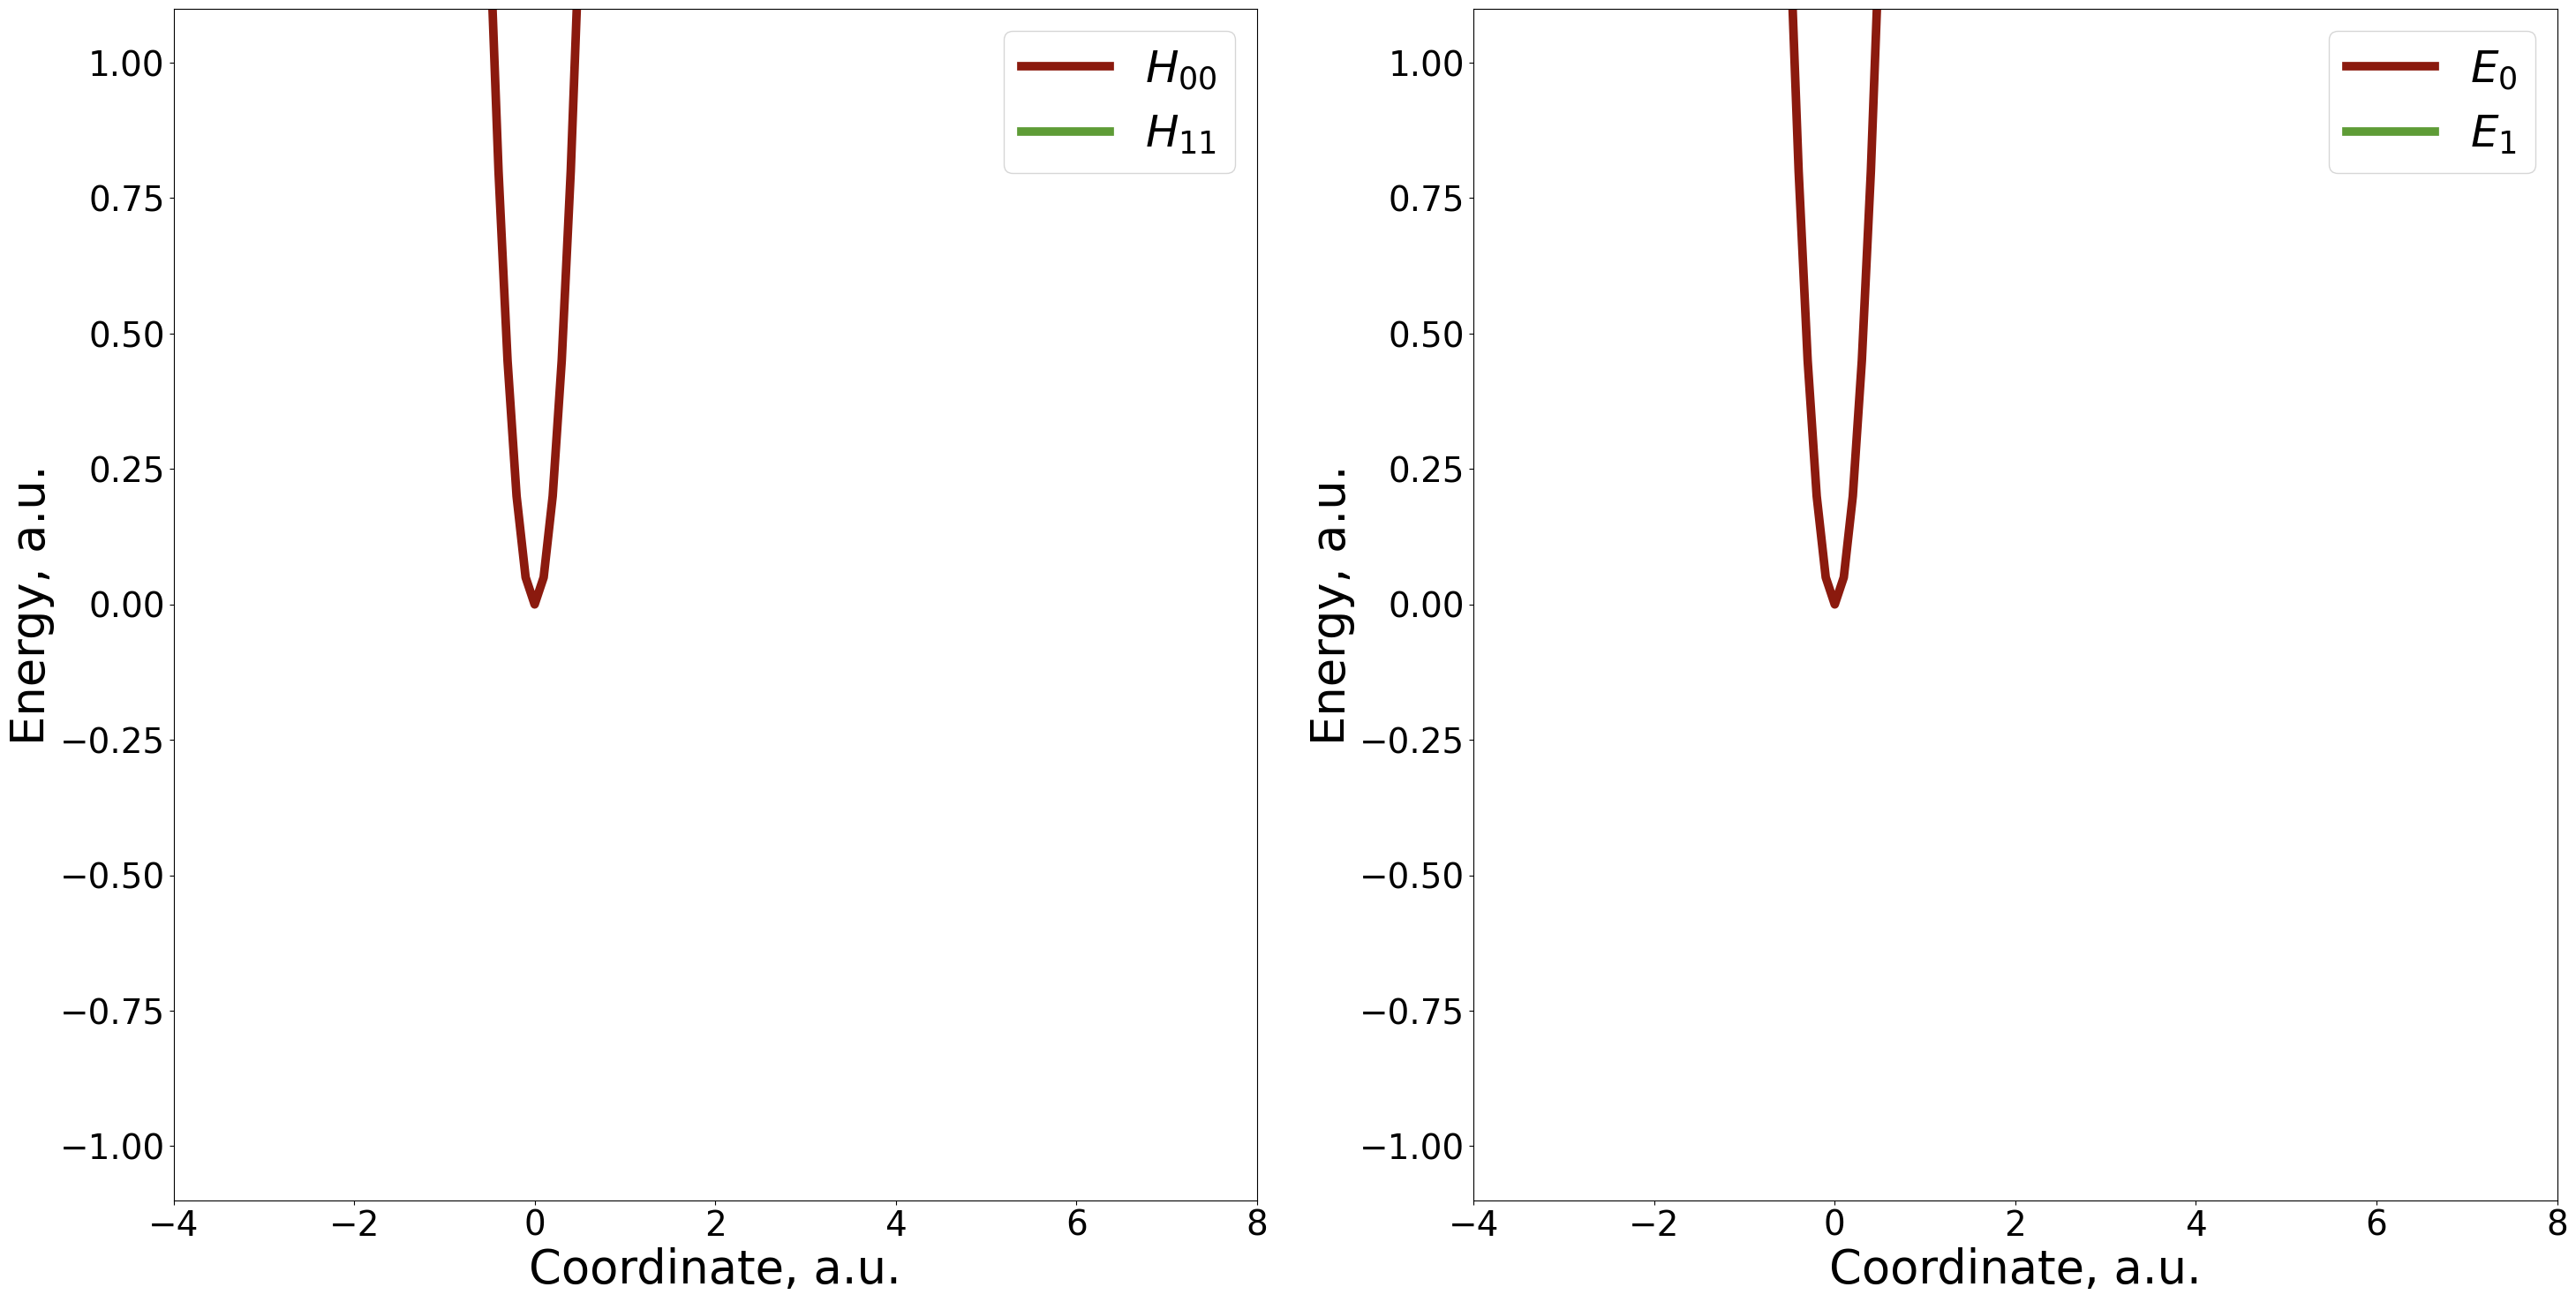

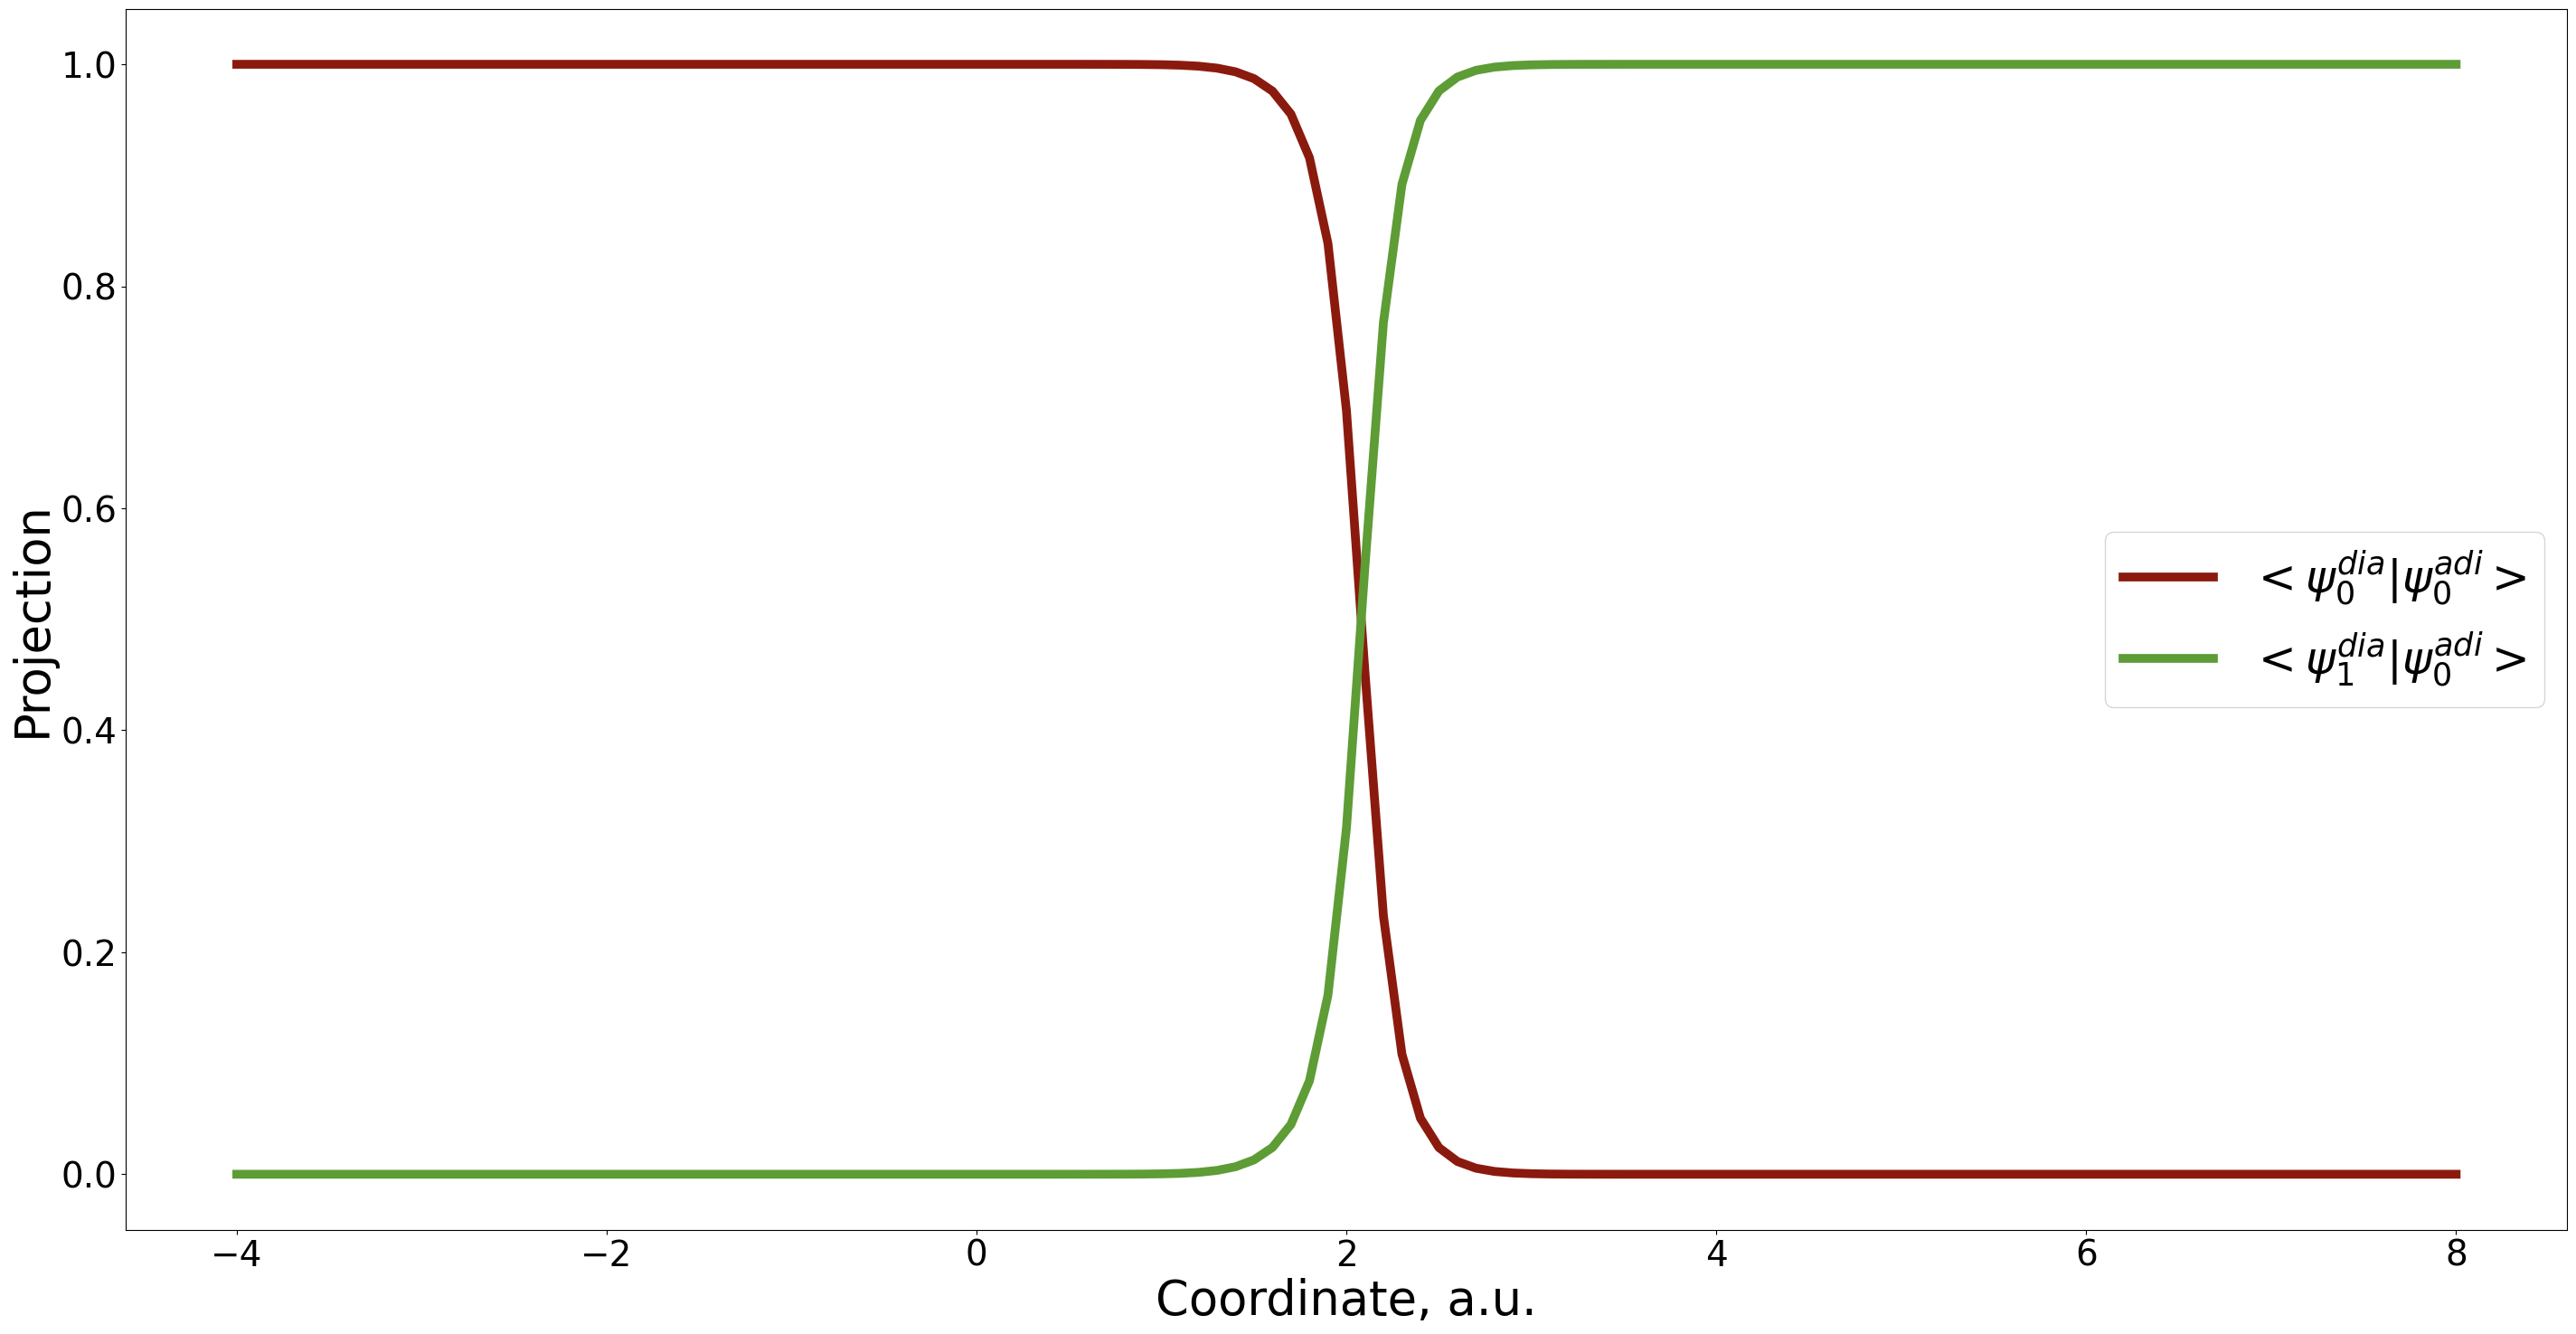

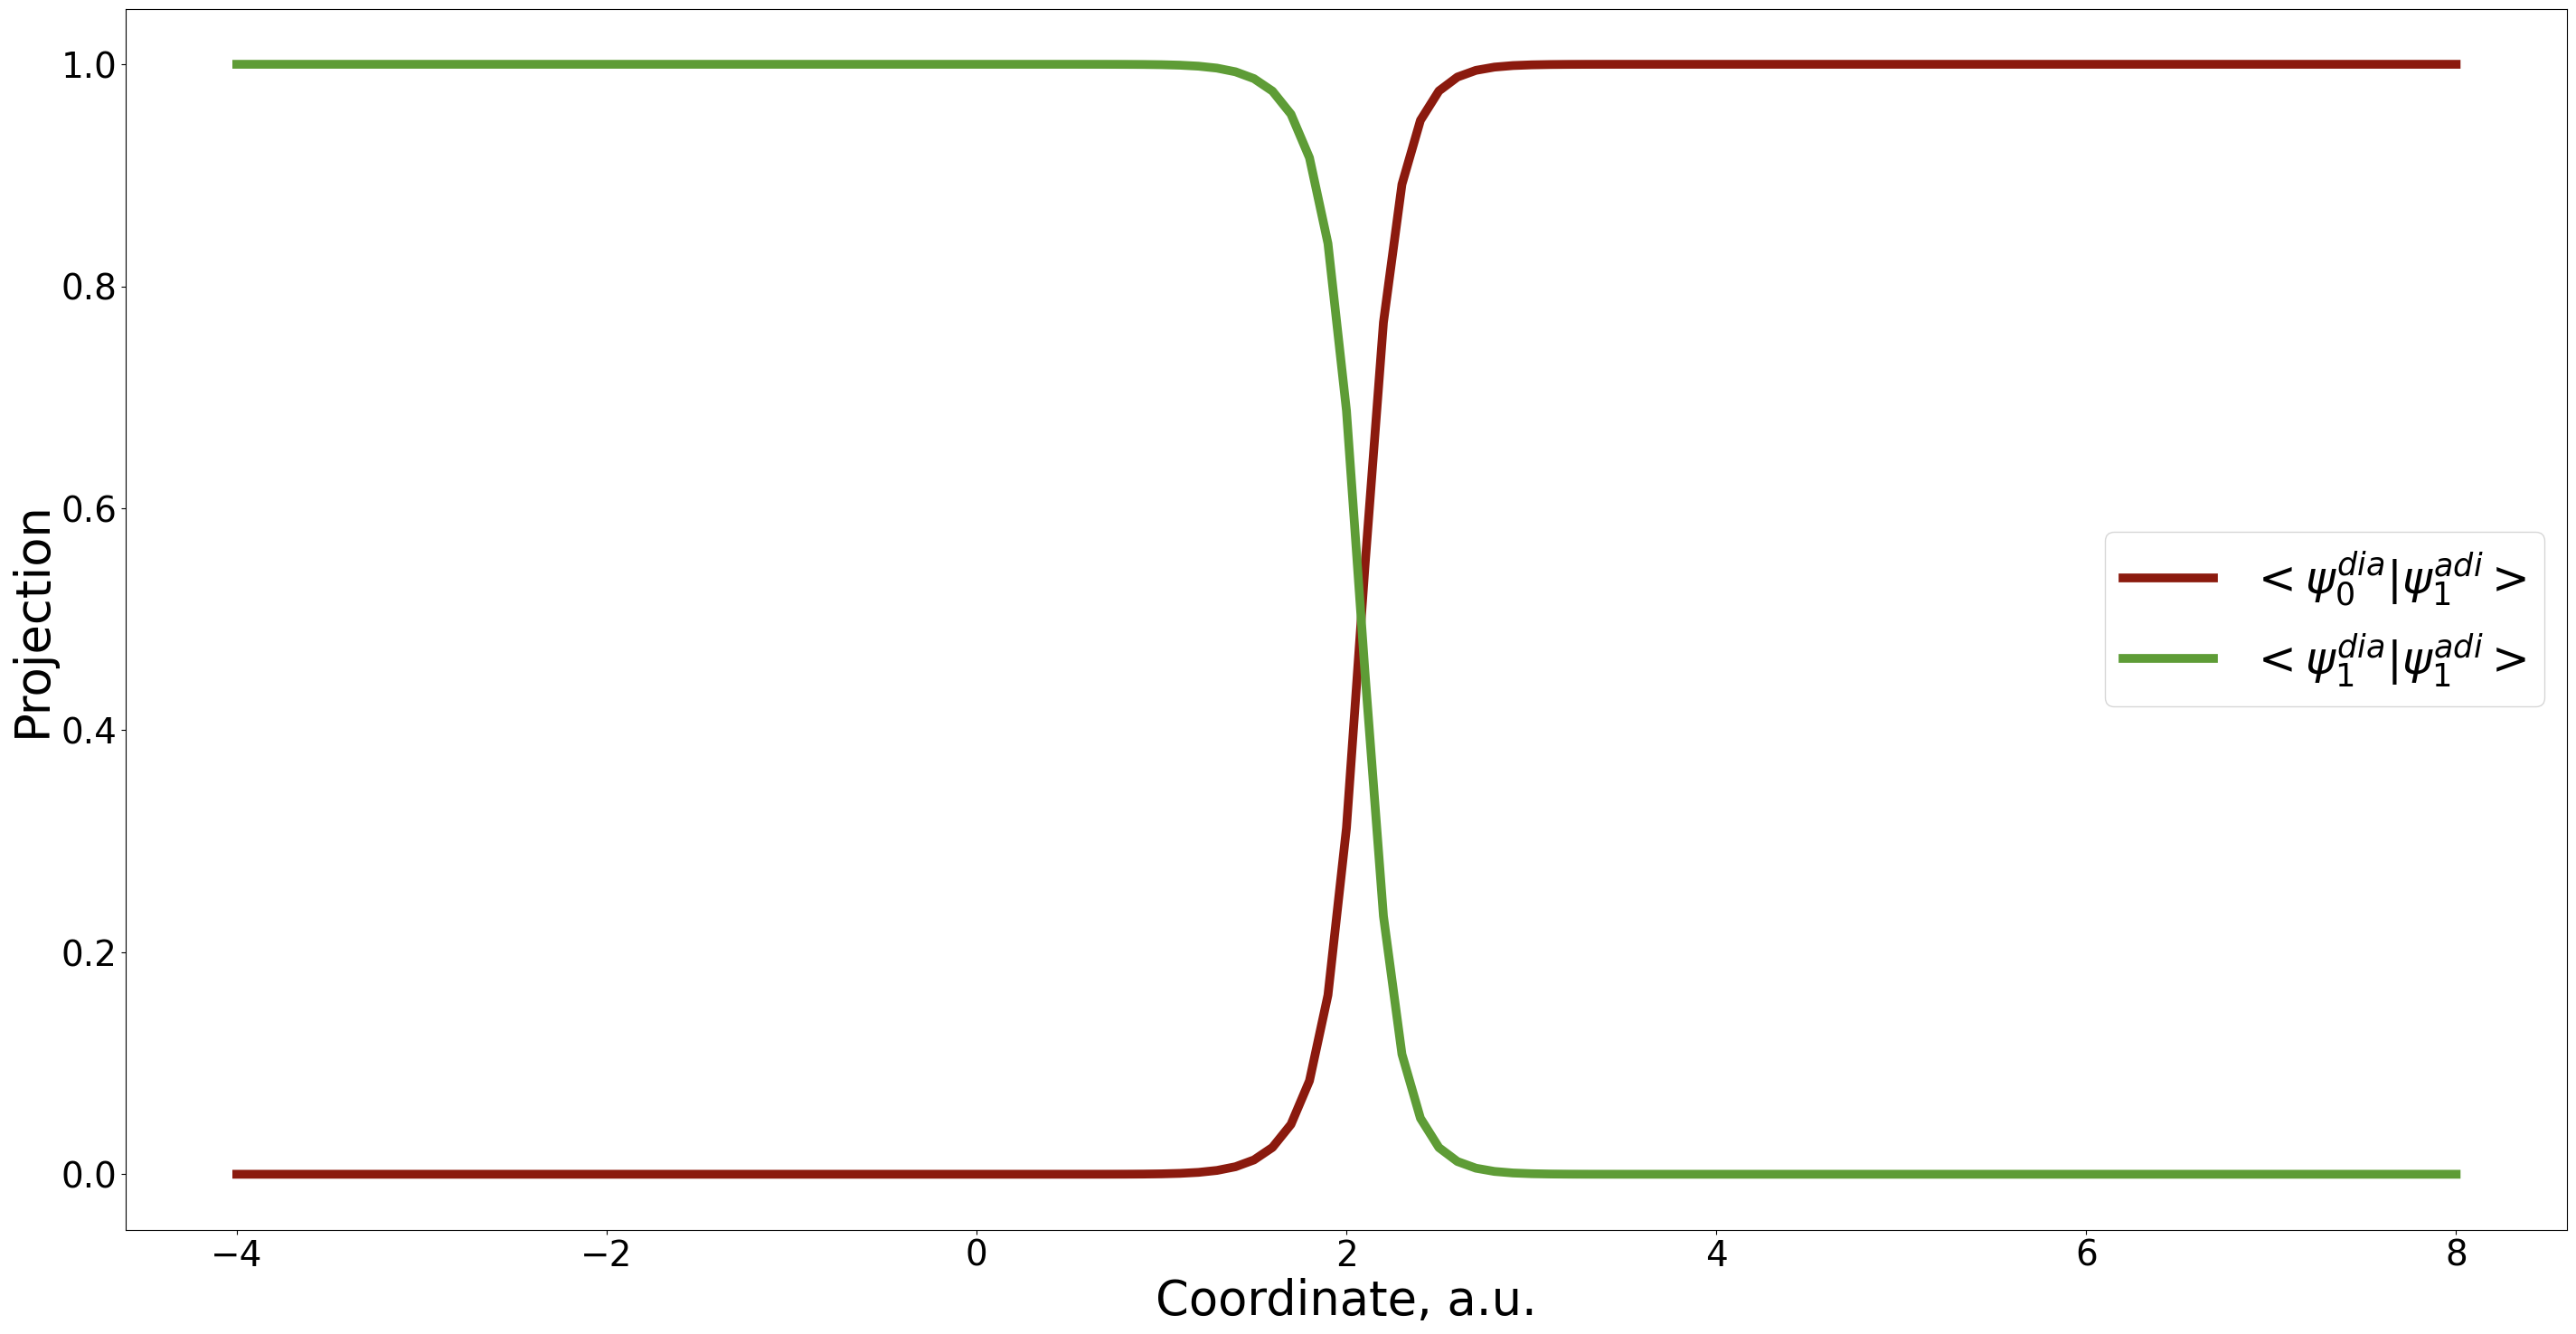

In [8]:
if case in [0, 1]:
    model_params['nstates'] = 2
    plot_params = {"xlim":[-4,8], "ylim":[-1.1,1.1]}
    dynamics_plotting.plot_surfaces(compute_model, [model_params], [0,1], -4.0, 8.0, 0.1, plot_params)

In [9]:
if case in [2]:
    model_params['nstates'] = 2
    plot_params = {"xlim":[-4,8], "ylim":[-0.1,0.1]}    
    dynamics_plotting.plot_surfaces(compute_model, [model_params], [0,1], -4.0, 8.0, 0.1, plot_params, _ndof=2, _active_dof=0, _all_coordinates=[0.0, 0.0])

<a name="dynamics_plotting-2"></a>
For the 2D models, we may specify the active DOF, along which we want to scan the coordinates

In [10]:
if case in [2]:
    plot_params = {"xlim":[-4,8], "ylim":[-1.1,1.1]}
    dynamics_plotting.plot_surfaces(compute_model, [model_params], [0,1], -4.0, 8.0, 0.1, plot_params, _ndof=2, _active_dof=1, _all_coordinates=[0.0, 0.0])

## 2. Setting up and executing QTAG dynamics

[Back to TOC](#Table-of-Contents) <a name="2"></a>

Next, we define the user interface for the QTAG method via the ``run_qtag`` function. This function, given a list of user-defined parameters for both the dynamics (``dyn_params``) and for the potential model (``model_params``), handles all of the interfacing with the qtag modules imported in the first cell. Specific details for this function can be seen below as in-line comments.

### 2.1. Initializing the grid (Gaussian Basis Functions, GBFs)

[Back to TOC](#Table-of-Contents) <a name="2.1"></a>
<a name="gbfs-1"></a>

In [11]:
#Parameters for general simulation
init_params_1D = {
    "init_placement":0,
    "wfc_q0":[-2.0], "wfc_p0":[0.0], "wfc_a0":[1.0], "wfc_s0":[0.0],
    "states":[0, 1],
    "grid_dims":[25], "alp_scl":[6.0], "rho_cut":1e-12
}

init_params_2D = {
    "init_placement":0,
    "wfc_q0":[0.0, 2.0], "wfc_p0":[0.0, 0.0], "wfc_a0":[1.0, 1.0], "wfc_s0":[0.0, 0.0],
    "states":[0, 1],
    "grid_dims":[5, 5], "alp_scl":[6.0, 6.0] , "rho_cut":1e-12
}

if case in [0, 1]:
    ntraj, Q, P, A, S, active_states = initialize.gbfs(init_params_1D)
elif case in [2]:
    ntraj, Q, P, A, S, active_states = initialize.gbfs(init_params_2D)

In [12]:
help(initialize.gbfs)

Help on function gbfs in module libra_py.dynamics.qtag.initialize:

gbfs(_params)
    Places the basis functions on all surfaces according to the `init_placement' parameter and
       initializes their qpas MATRIX objects.
    
    Args:
        _params (dict): Dictionary containing simulation parameters.
    
          * **_params[`init_placement`]** (float) : a parameter controlling how the initial placement
              of the basis functions is handled; 
          
            - 0: grid [ default ]
            - 1: gaussian distributed
    
    
    Also see:
        Parameters of the `grid` and `gaussian` functions
    
    
    Returns:
        (ntraj, Q, P, A, S, active_states): where:
    
        ntraj (int): The total number of trajectories across all surfaces. 
        Q (MATRIX(ndof, ntraj) ): coordinates of the GBFs
        P (MATRIX(ndof, ntraj) ): momenta of the GBFs
        A (MATRIX(ndof, ntraj) ): widths of the GBFs
        S (MATRIX(ndof, ntraj) ): total phases of t

In [13]:
print(ntraj, active_states)

50 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 2.2. Initializing the wavefunction

[Back to TOC](#Table-of-Contents) <a name="2.2"></a>

First, we prepare the coordinates, momenta, width, and phase variables in the MATRIX format using the `wfc_centers` function.

Then, we use the resulting objects, together with the GBFs information to compute the amplitudes on each of the GBF by projecting the initial Gaussian wavepacket to those functions. This is done by the `coeffs` function.
<a name="wfc_centers-1"></a>
<a name="coeffs-1"></a>

In [14]:
if case in [0, 1]: # 1D case
    Q0, P0, A0, S0 = initialize.wfc_centers(init_params_1D)    
elif case in [2]: # 2D case
    Q0, P0, A0, S0 = initialize.wfc_centers(init_params_2D)

istate = [0]
C = initialize.coeffs(Q0, P0, A0, S0, istate, Q, P, A, S, active_states)

In [15]:
data_outs.print_matrix(C)

(3.022623418647962e-10+0j)  
(7.697816072614085e-09+0j)  
(1.5837817405651728e-07+0j)  
(2.4393330479985983e-06+0j)  
(2.8167586838768934e-05+0j)  
(0.00024392366003086292+0j)  
(0.0015839923570392725+0j)  
(0.007713531749931392+0j)  
(0.02816781868002284+0j)  
(0.0771353112004264+0j)  
(0.15839928876335166+0j)  
(0.24392326944228349+0j)  
(0.281678194649702+0j)  
(0.24392326938762013+0j)  
(0.15839928874124354+0j)  
(0.07713531127364531+0j)  
(0.028167818662253364+0j)  
(0.007713531740305955+0j)  
(0.0015839923609536066+0j)  
(0.0002439236598844631+0j)  
(2.8167584515102068e-05+0j)  
(2.4393416248394417e-06+0j)  
(1.583649519229513e-07+0j)  
(7.720954323803264e-09+0j)  
(2.8826464674482077e-10+0j)  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  
0j  


### 2.3. Running the dynamics

[Back to TOC](#Table-of-Contents) <a name="2.3"></a>

First, let's set up the parameters of the simuation

In [16]:
if case in [0, 1]:  # 1D
    iM = MATRIX(1, 1);  iM.set(0,0,1.0);
elif case in [2]:  # 2D
    mx, my = 20000.0, 6667.0
    mass = MATRIX(2,1); mass.set(0,0,mx); mass.set(1,0,my)
    iM = MATRIX(2,1); iM.set(0,0,1.0/mx); iM.set(1,0,1.0/my)

#Parameters for general simulation
dyn_params = {
    "qtag_pot_approx_method":0,
    "target_states":[0,1], "states":[0,1], "iM":iM, 
    "q_update_method":1, "p_update_method":1, "a_update_method":1, "s_update_method":0,  
    "q_sync_method":1, "p_sync_method":0, "a_sync_method":0, "s_sync_method":0,
    "mom_calc_type":1, "linfit_beta":1e-3, "decpl_den":0.01, "d_weight":1.0,    
    "dt":1.0, "nsteps":200,
    "prefix":"out",  "progress_frequency": 10, 
    "hdf5_output_level":0, "txt2_output_level":3, 
    "properties_to_save":["time","Etot","pops","q","p","a","coeffs"],    
}

if case in [0, 1]:    
    dyn_params.update({ "dt":0.01, "nsteps":800, "qtag_pot_approx_method":3 })
elif case in [2]:
    dyn_params.update({ "dt":1.0, "nsteps":100, "qtag_pot_approx_method":0 })

Once the parameters are set, we're ready to run QTAG! The output directory is specified using the `data_dir` variable, and the code is executed with the `run_qtag` function.
<a name="run_qtag-1"></a>

In [17]:
help(compute.run_qtag)

Help on function run_qtag in module libra_py.dynamics.qtag.compute:

run_qtag(_q, _p, _alp, _s, _states, _coeff, _iM, _dyn_params, _compute_model, _model_params)
    Args: 
        _q ( MATRIX(nnucl, ntraj) ): coordinates of the "classical" particles [units: Bohr]
        _p ( MATRIX(nnucl, ntraj) ): momenta of the "classical" particles [units: a.u. of momenta]
        _alp ( MATRIX(nnucl, ntraj) ): widths of the GBFs [ units: Bohr^-1 ]
        _s ( MATRIX(1, ntraj) ): phases of all GBFs [ units: no ]
        _states ( intList, or list of ntraj ints ): the quantum state of each trajectory
        _coeff ( CMATRIX(nstates x ntraj) ): amplitudes of the GBFs
        _iM ( MATRIX(nnucl, 1) ): masses of classical particles [units: a.u.^-1]
        _dyn_params ( dictionary ): parameters controlling the execution of the dynamics
            Can contain:
    
            * **q_update_method** (int): the parameter specifying whether positions should be updated (adaptable) or frozen  
    
     

In [18]:
compute.run_qtag(Q, P, A, S, active_states, C, iM, dyn_params, compute_model, model_params)

21.055555554604833 [0.9999999999573986, 4.7660531610916416e-14]
21.02357572590781 [0.9999999996336931, 8.168400013411798e-12]
21.038276923290987 [0.9999999995105966, 4.27280305315916e-12]
21.09888790237565 [0.9999999991216267, 1.3359856216423345e-10]
21.165267151908463 [0.9999999935904612, 5.828199953842978e-09]
21.198116265283232 [0.9999993118406767, 6.876491941309937e-07]
21.1819252599726 [0.9999470270548927, 5.2968415981817716e-05]
21.120642204581088 [0.9988603107198739, 0.001139630196894837]
21.032506585604573 [0.9926552749004969, 0.0073446216355733136]
20.927217399608605 [0.9771231380525566, 0.022876756553687268]
20.85180257626673 [0.9517306439045838, 0.048269250629178306]
20.809484926157687 [0.9189264919708193, 0.08107340242068344]
20.819191027148175 [0.8839452243590622, 0.11605466985987345]
20.87876482354878 [0.8587109683422214, 0.14128892501034285]
20.945279194202268 [0.8513060011422904, 0.14869389000957015]
20.97455440880126 [0.8526413247048488, 0.1473585662832319]
20.95578126

(<liblibra_core.MATRIX at 0x7facb57f6bb0>,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 <liblibra_core.CMATRIX at 0x7faca92f38f0>)

## 3. Data Visualization

[Back to TOC](#Table-of-Contents) <a name="3"></a>

With the simulation finished, we can start plotting some of the output data we requested via the `properties_to_save` parameter in the `dyn_params` dictionary.

Note that a new dictionaries are usually used for each kind of plotting: `wfc_plt_params` - for wavefunction plotting, `en_plt_params` - for energy and population plotting, `traj_plt_params` - for plotting coordinates/momenta/width of GBFs. 

### 3.1. Wavefunction plotting

[Back to TOC](#Table-of-Contents) <a name="3.1"></a>

First, we're plotting the probability density at various snapshots in the simulation using the `plot.wf_plot` function, which relies on gridded wavefunction data reconstructed from our output via the `compute.wf_calc_nD` function.

In [19]:
#Plot parameters dictionary definitions for wavefunction output...
wfc_plt_params = {'prefix':dyn_params['prefix'], 'which_states':[0,1], "states":[0,1],
              'size':[16,16], 'legend_loc':[0.6,0.8], 'legend_size':12,
              '1Dcolors':['Black','Blue'], '2Dcolors':['Reds','Blues']
              }

if case in [0, 1]:
    wfc_plt_params.update({ "ndof":1, 'xmin':[-4.0],'xmax':[4.0], 
                        'npoints':[100], 'snaps':[0,199,399,599,799],
                        "grid_dims":init_params_1D["grid_dims"]
                      })
    
elif case in [2]:
    wfc_plt_params.update({ "ndof":2, 'xmin':[-2.0, -4.0],'xmax':[6.0, 4.0], 
                        'npoints':[25, 25], 'snaps':[0,39,79],
                        "grid_dims":init_params_2D["grid_dims"]
                      })

To plot the wavefunctions, we first wound need to reconstruct it on a specified grid using `wf_calc_nD` function:
<a name="wf_calc_nD-1"></a>

In [20]:
#Call wf_calc_nD to calculate gridded wavefunction data from coefficients and qpas output...
compute.wf_calc_nD(wfc_plt_params)

In [21]:
help(compute.wf_calc_nD)

Help on function wf_calc_nD in module libra_py.dynamics.qtag.compute:

wf_calc_nD(_params)
    Computes the wavefunction on an nD-dimensional grid, as specified by the parameters obtained
    from the dyn_params and plt_params dictionaries.
    
    Args:
        _params (dict): Dictionary containing control parameters.
    
          * **_params[`states`]** (list of ints) : list of all states in data
    
          * **_params[`grid_dims`]** (list of floats) : the total number of basis functions to be
              placed on each surface. For Gaussian, the list has only one element, specifying the
              number of basis functions per surface. Note that the total number of basis functions
              will then be *nstates*-by-*prod(grid_dims)*
    
          * **_params[`ndof`]** (int) : the number of degrees of freedom [ default: 1 ]
                  
          * **_params[`xmin`]** (list of floats) : list of minima in the independent coordinate space
              at which 

And then we can plot the snapshots
<a name="wf_plot-1"></a>

Number of files = 5


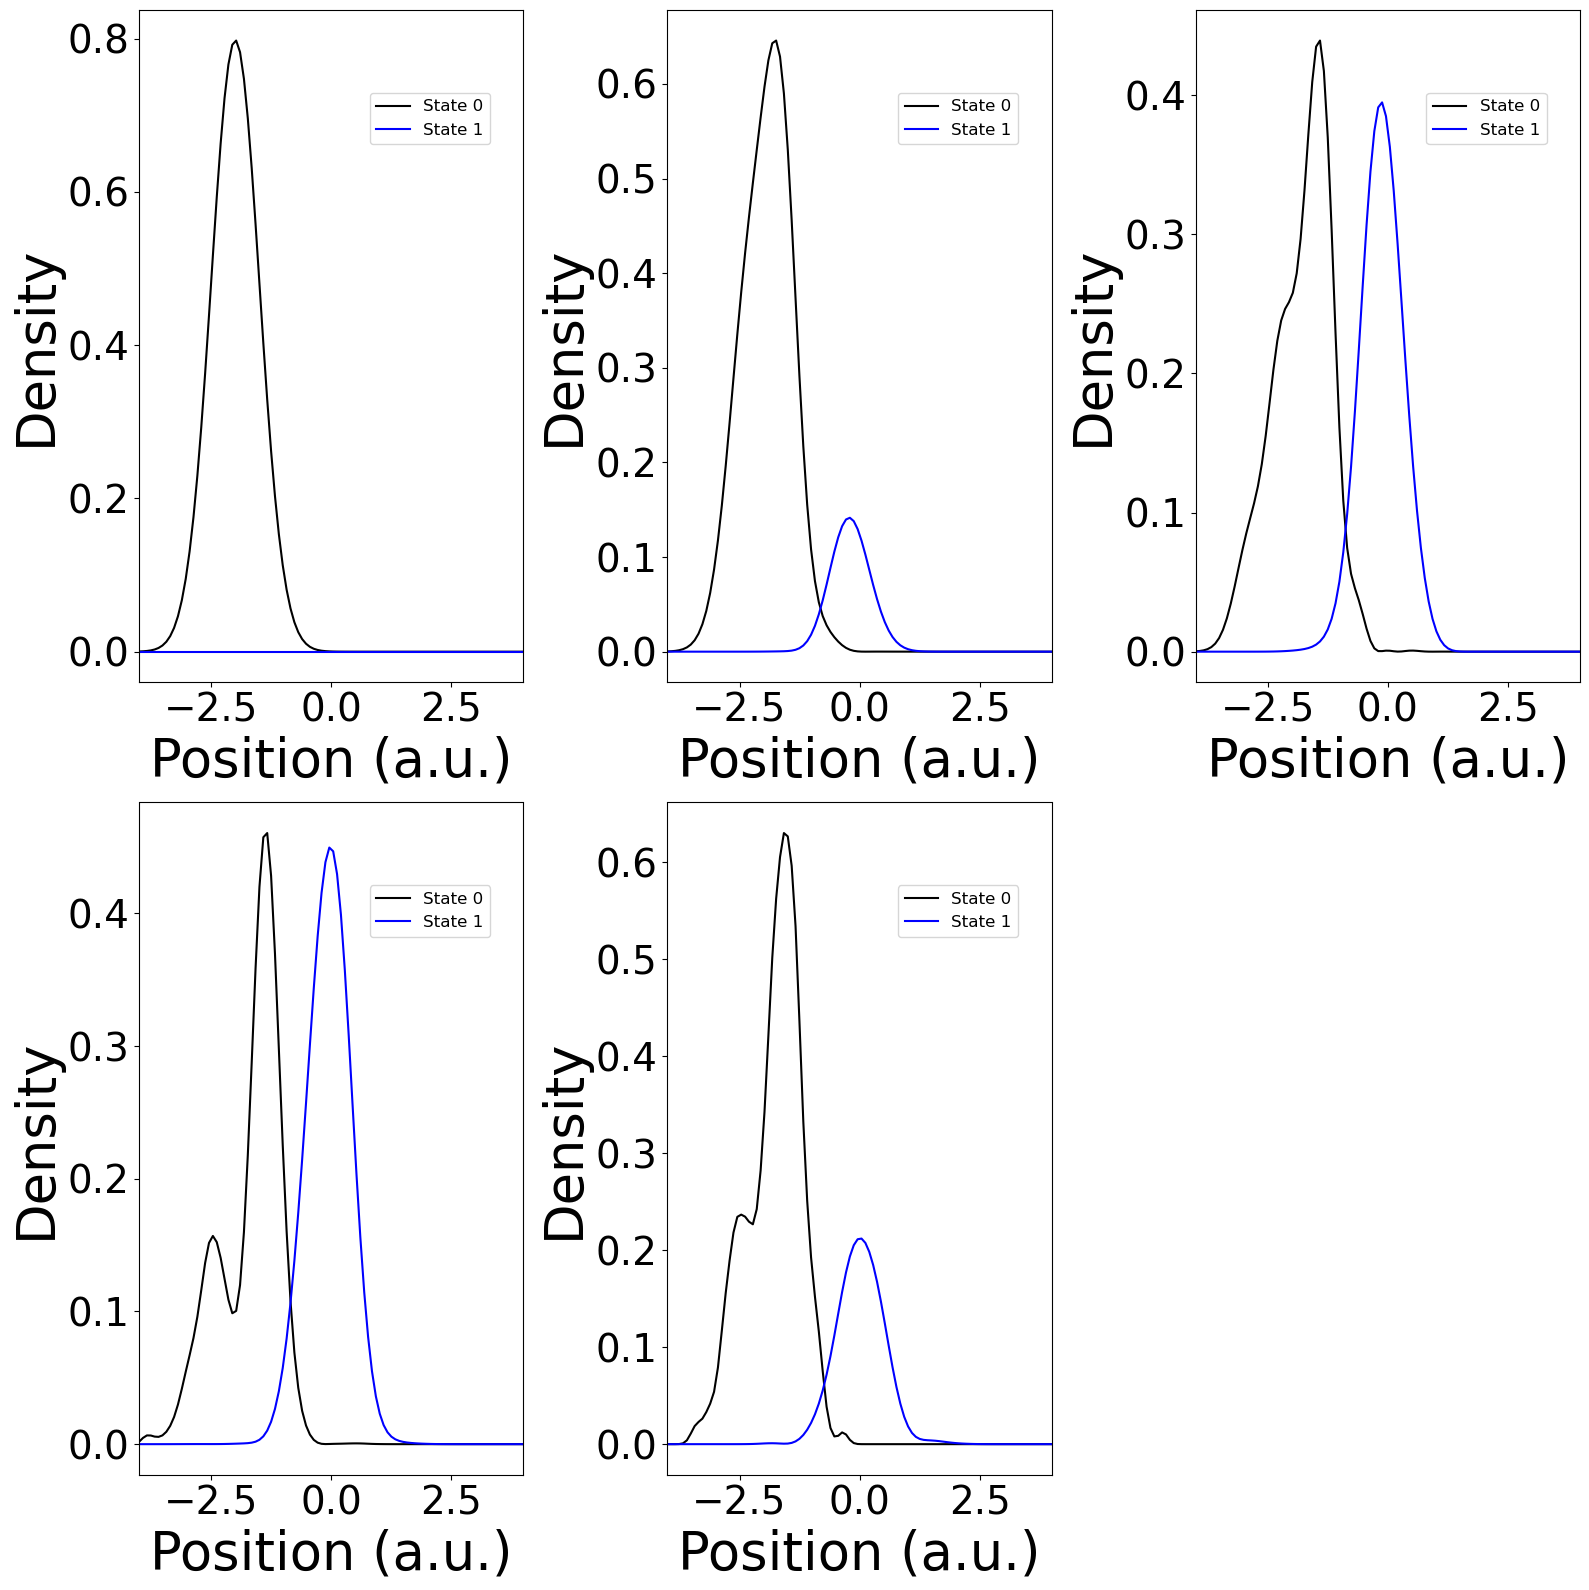

In [22]:
#Plot the selected snapshots...
plot.wf_plot(wfc_plt_params)

In [23]:
help(plot.wf_plot)

Help on function wf_plot in module libra_py.dynamics.qtag.plot:

wf_plot(_plt_params)
    Plots 1D or 2D wavefunctions
    
    Args:
        _plt_params (dict): Dictionary containing plot control parameters.
    
          * **_plt_params[`ndof`]** (int) : the number of nuclear degrees of freedom in data [ default : 1 ]
    
          * **_plt_params[`states`]** (list of ints) : the states present in the output data [ default: [0] ]
    
          * **_plt_params[`prefix`]** (string) : the name of the subdirectory where QTAG output is stored [ default: "out" ]
    
          * **_plt_params[`npoints`]** ( list of ints) : how many points to use in the plotting [ default: [100] for 1D, and [25, 25] for 2D ]
    
    Also see: see docs for `plot_wf_1D` or `plot_wf_2D` for the following parameters:
    
          * **_plt_params[`which_states`]**
    
          * **_plt_params[`xmin`]**
    
          * **_plt_params[`xmax`]**
    
          * **_plt_params[`snaps`]**
    
          * **_

There are slight differences in the format of parameters for 1D plotting:
<a name="plot_wf_1D-1"></a>

In [24]:
help(plot.plot_wf_1D)

Help on function plot_wf_1D in module libra_py.dynamics.qtag.plot:

plot_wf_1D(_plt_params, data)
    Plots the 1D wavefunction
    
    Args:
        _plt_params (dict): Dictionary containing plot control parameters.
    
          * **_plt_params[`which_states`]** (list of ints) : the list containing surfaces for which data is to be plotted 
              [default : [0] ] 
    
          * **_plt_params[`xmin`]** ( list: [float] ) : the domain minimum for the plot [ default: [-4.0] ]
    
          * **_plt_params[`xmax`]** ( list: [float] ) : the domain maximum for the plot [ default: [4.0] ]
    
          * **_plt_params[`snaps`]** (list of ints) : for which timesteps to plot the wavefunction [ default: [0] ]
    
          * **_plt_params[`size`]** ( list: [int, int] ): size of the plot [ default: [16,16] ]
    
          * **_plt_params[`xlabel`]** ( string ): x label of the plot [ default: "Position (a.u.)"]
    
          * **_plt_params[`ylabel`]** ( string ): y label of the 

and for 2D plotting:
<a name="plot_wf_2D-1"></a>

In [25]:
help(plot.plot_wf_2D)

Help on function plot_wf_2D in module libra_py.dynamics.qtag.plot:

plot_wf_2D(_plt_params, data)
    Plots the 2D wavefunction
    
    Args:
        _plt_params (dict): Dictionary containing plot control parameters.
    
          * **_plt_params[`which_states`]** (list of ints) : the list containing surfaces for which data is to be plotted
              [default : [0] ]
    
          * **_plt_params[`xmin`]** ( list: [float, float] ) : the domain minimum for the plot [ default: [-4.0, -4.0] ]
    
          * **_plt_params[`xmax`]** ( list: [float, float] ) : the domain maximum for the plot [ default: [4.0, 4.0] ]
    
          * **_plt_params[`snaps`]** (list of ints) : for which timesteps to plot the wavefunction [ default: [0] ]
    
          * **_plt_params[`size`]** ( list: [int, int] ): size of the plot [ default: [16,16] ]
    
          * **_plt_params[`xlabel`]** ( string ): x label of the plot [ default: "X Coordinate (a.u.)"]
    
          * **_plt_params[`ylabel`]** 

### 3.2. Energy and population plotting

[Back to TOC](#Table-of-Contents) <a name="3.2"></a>

Now, we plot the surface populations and energy conservation using the `plot.energy_and_pops` function:
<a name="energy_and_pops-1"></a>

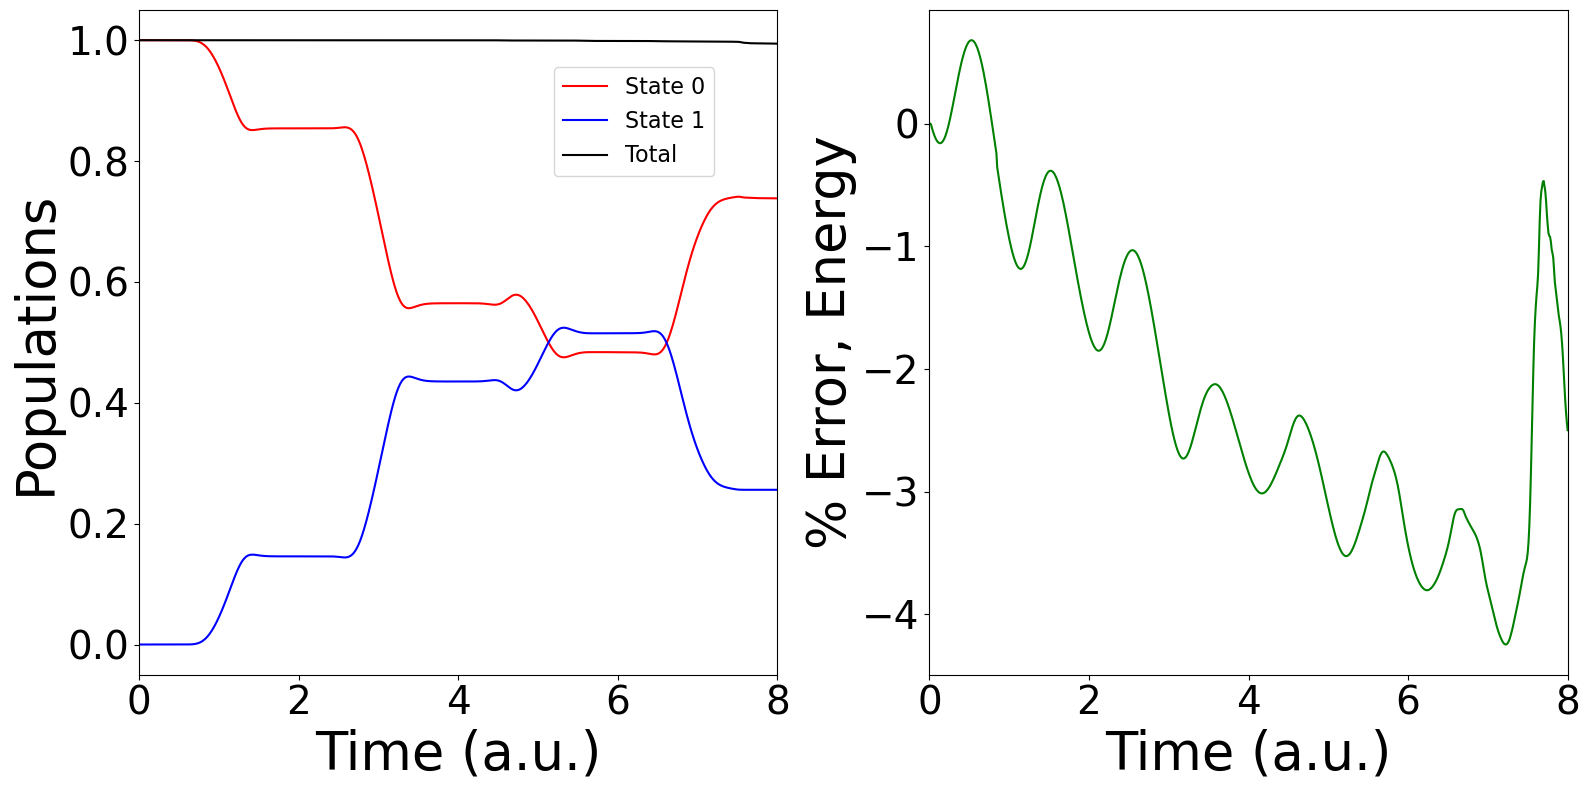

In [26]:
#Plot parameters dictionary definitions for energy/population output...
en_plt_params = {"nsteps":dyn_params["nsteps"], "states":[0, 1],
                 'prefix':"out", 'size':[16,8], 'xmin':[0], 'xmax':[ dyn_params["dt"]*dyn_params["nsteps"] ], 
                 '1Dcolors':['Red','Blue'], 'legend_loc':[0.65,0.75], 'legend_size':16
                }

#Plot the graphs...
plot.energy_and_pops(en_plt_params)

In [27]:
help(plot.energy_and_pops)

Help on function energy_and_pops in module libra_py.dynamics.qtag.plot:

energy_and_pops(_plt_params)
    Args:
        _plt_params (dict): Dictionary containing simulation parameters.
    
          * **_plt_params[`nsteps`]** (int) : the number of simulation steps [ default: 1 ]
    
          * **_plt_params[`states`]** (list of ints) : the states present in the output data [ default: [0] ]
    
          * **_plt_params[`ndof`]** (int) : the number of degrees of freedom [ default: 1 ]
    
          * **_plt_params[`prefix`]** (string) : the name of the subdirectory where QTAG output is stored
    
          * **_plt_params[`xmin`]** (list of floats) : the list of domain minima for the plot [ default : [0.0] ]
    
          * **_plt_params[`xmax`]** (list of floats) : the list of domain maxima for the plot [ default: [1.0] ]
    
          * **_plt_params[`1Dcolors`]** ( list of strings ): color names for each surface, should be of the same shape as
            `which_states` [ de

### 3.3. Trajectory information plotting

[Back to TOC](#Table-of-Contents) <a name="3.3"></a>

We can also plot the evolution of the GBF parameters - coordinates, momenta, and width parameters using the `plot.trajectories` function:
<a name="trajectories-1"></a>

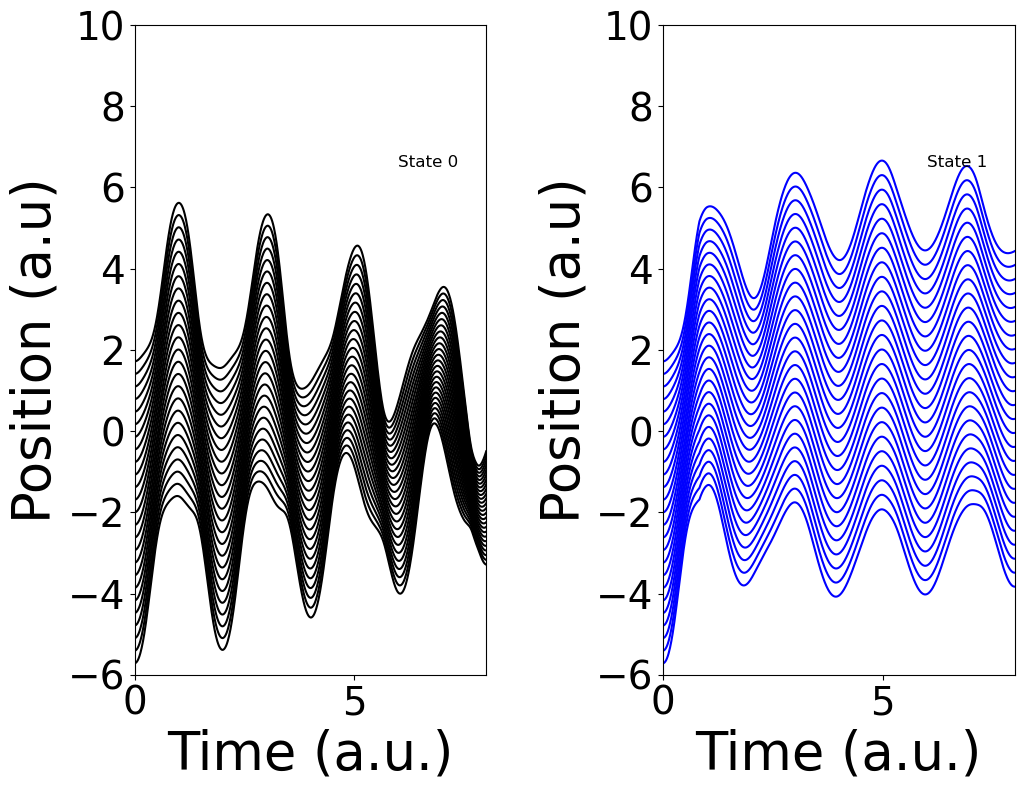

In [28]:
Xmax = dyn_params["dt"]*dyn_params["nsteps"]

#Plot parameters dictionary definitions for trajectory output...
traj_plt_params = {'prefix':"out", "states":[0,1], 'which_states':[0, 1], 'which_traj':'all', 
                   'size':[16,8], 'xlabel':'Time (a.u.)', 'ylabel':'Position (a.u)', 'zlabel':'N/A',
                   '1Dcolors':['Black','Blue'],
                   'xmin':[0.0, -6.0],'xmax':[ Xmax, 10.0 ],
                   "data_type":0
                  }

#Plot the output...
if case in [0, 1]:
    traj_plt_params.update({"ndof":1, "active_dof":0, 
                            "grid_dims":init_params_1D["grid_dims"]  })    
elif case in [2]:
    traj_plt_params.update({"ndof":2, "active_dof":0, 
                            "grid_dims":init_params_2D["grid_dims"]  })
    
plot.trajectories(traj_plt_params)

In [29]:
help(plot.trajectories)

Help on function trajectories in module libra_py.dynamics.qtag.plot:

trajectories(_plt_params)
    Args:
        _plt_params (dict): Dictionary containing simulation parameters.
    
          * **_plt_params["data_type"]** (int): 0 - coordinates, 1 - momenta, 2 - width parameters [default: 0]
    
          * **_plt_params[`grid_dims`]** (list of ints) : the *grid_dims* list used to specify the initial basis passed to initialize.py
    
          * **_plt_params[`states`]** (list of ints) : the states present in the output data [ default: [0] ]
    
          * **_plt_params[`ndof`]** (int) : the number of degrees of freedom [ default: 1 ]
    
          * **_plt_params[`prefix`]** (str) : the name of the subdirectory where QTAG output is stored
    
          * **_plt_params[`which_states`]** (list of ints) : the list containing surfaces for which data is to be plotted
    
          * **_plt_params["which_traj"]** (list of ints or string) : the list of trajectories to print
    
  

## 4. Exercises

[Back to TOC](#Table-of-Contents) <a name="exercises"></a>

### 4.1. Exercise 1

Compute the dynamics for longer dynamics. At what time does the simulation may be considered failed? Discuss

### 4.2. Exercise 2

Compute the dynamics using other QTAG potential approximations. Which one(s) work(s) the best? Why?

### 4.3. Exercise 3

Vary the trajectory initialization methods and the number of trajectories. How do the results change? Does increasing the number of trajectories help you simulate the dynamics for a longer time without becoming vastly incorrect?

### 4.4. Exercise 4

Try freezing the dynamics of certain parameters of the Gaussians. What do you expect to see as an outcome? Do your simulations reinforce your expectations?

### 4.5. Exercise 5

Try varying the synchronization algorithms for various parameters of the Gaussians. What do you expect to see as an outcome? Do your simulations reinforce your expectations?

### 4.6. Exercise 6

Try running the dynamics for a different potential - either your own or one from the Libra models database. What do you expect the outcomes to look like? Do your simulations agree with your excpectations? Discuss.

### 4.7. Exercise 7

Run the dynamics with 2D model. Analyze results. Discuss if the outcomes of the simulations you have conducted meet your expectations.

### 4.8. Exercise 8

Run the dynamics with a user-defined 1D model. Use the provided code block as a template to code your own model. Run simulations with your own Hamiltonian. Consider adjusting the parameters and initial conditions as appropriate.

### 4.9. Exercise 9

For a pre-computed dynamics with a 1D model, plot evolution of momenta and width parameters

### 4.10. Exercise 10

For a pre-computed dynamics with a 2D model, plot evolution of both componentes of the coordinate